In [2]:
# Imports
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from BayesianNamingGame import *
import os
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib import ticker

Populating the interactive namespace from numpy and matplotlib


# Preprocess results 

## Step 1: aggregation

The results of the many runs still have to be aggregated, before we can anlyze the effect of the parameters properly.

In [3]:
def analyze(gammas, etas, zetas, skipexisting=True,
            runs=1, firstrun=1, root='../../results/BNG06'):
    """Analyze multiple simulations and dump the results to csv files.

    It reads out all the results of the simulation with each of the 
    parameter settings (gamma, eta, zeta), then compute aggregate results
    for those settins and dumps those to a file.
    
    Args:
        gammas: iterable with values of gamma to analyze
        etas: iterable with etas
        zetas: iterable with zetas
        runs: the number of runs to analyze
        firstrun: number of the first run
        root: the directory in which to look
    """
    for gamma in gammas:
        for eta in etas:
            for zeta in zetas:
                print(f'\n>>> Start gamma={gamma}, eta={eta}, zeta={zeta}')
                name = f'BNG06-gamma-{gamma}-eta-{eta}-zeta-{zeta}'
                directory = os.path.join(root, f'gamma-{gamma}/eta-{eta}')
                src_fn = os.path.join(directory, name+'-run-{:0>4}')
                stats_fn = os.path.join(directory, name+'-stats.csv')
                divs_fn = os.path.join(directory, name+'-divs.csv')

                if not os.path.exists(src_fn.format(firstrun)): 
                    print('Does not exist, continuing')
                    continue
                    
                # Skip existing
                if skipexisting and os.path.exists(stats_fn) and os.path.exists(divs_fn):
                    print('Exists, skipping.')
                    continue

                # Analyse and dump
                div_df, stats_df, _ = analyze_BNG_simulation_runs(src_fn, runs, firstrun=firstrun)
                stats_df.to_csv(stats_fn)
                div_df.to_csv(divs_fn)

In [179]:
gammas = ['inf']# [1, 5, 10, 50, 100, 1000, 'inf']
etas = [1, 2, 5, 50, 'inf']
zetas = [1, 1.5, 2, 5, 'inf']

In [ ]:
analyze(gammas, etas, zetas, runs=20, skipexisting=False)

## Step 2: portable format

In [4]:
# Load all data

gammas = [1, 5, 10, 50, 100, 1000, 'inf']
etas = [1, 2, 5, 50, 'inf']
zetas = [1, 1.5, 2, 5, 'inf']

#######################
fn = '../../results/BNG06/gamma-1/eta-1/BNG06-gamma-1-eta-1-zeta-1-run-{:0>4}'
params = load_BNG_simulation(fn.format(1), params_only=True)

dfs = []
for gamma in gammas:
    for eta in etas:
        for zeta in zetas:
            directory = f'../../results/BNG06/gamma-{gamma}/eta-{eta}/'
            name = f'BNG06-gamma-{gamma}-eta-{eta}-zeta-{zeta}-stats.csv'
            fn = os.path.join(directory, name)
            if os.path.exists(fn):
                df = pd.read_csv(fn, index_col=0)
                df['gamma'] = gamma
                df['eta'] = eta
                df['zeta'] = zeta
                dfs.append(df)
        
# Combine in one Dataframe
df = pd.concat(dfs)
df.index = [df['gamma'], df['eta'], df['zeta']]

# Normalize entropies, JSDs etc.
N, K, T = params['N'], params['K'], params['T']
df['jsd_phis'] = df['jsd_phis'] / np.log2(N)
df['jsd_alpha_mphi'] = df['jsd_alpha_mphi'] / np.log2(2)
df['entropy_mphi'] = df['entropy_mphi'] / np.log2(K)
df['jsd_mphi_psi'] = df['jsd_mphi_psi'] / np.log2(2)
df['entropy_psi'] = df['entropy_psi'] / np.log2(K)
df['jsd_psi_alpha'] = df['jsd_psi_alpha'] / np.log2(2)

slice_size = 2000
slices = T//slice_size
df['jsd_psi_slices'] = df['jsd_psi_slices'] / np.log2(slices)   

df['reflectance'] = 1 - df['jsd_alpha_mphi']
df['coherence'] = 1 - df['jsd_phis']
df['synonymy'] = df['entropy_mphi']

# Export as a portable CSV
df.to_csv('BNG06-results.csv')

# Analysis

The result of all the preprocessing is stored in a CSV file, so we don't need the raw data to do the analyses.

In [5]:
# Load parameters (copy of params of gamma=eta=zeta=1)
params = json.load(open('BNG06-params.json'))
for k, v in params.items():
    if type(v) == list:
        params[k] = array(v)

# Read out data
df = pd.read_csv('BNG06-results.csv')
df.index = [df['gamma'], df['eta'], df['zeta']]
# del df['gamma'], df['eta'], df['zeta']

# Compute the means
means = df.mean(axis=0, level=[0,1,2])

# Entropy of prior
alpha_ps = params['alpha'] / params['alpha'].sum()
entropy_alpha = entropy(alpha_ps) / np.log2(params['K'])

In [6]:
settings = {
    'entropy_mphi': {
        'title': r'Relative entropy of mean distribution: $\hatH(\bar{\varphi})$',
        'vmin': 0, 'vmax':1,
        'annotate_cb': [
            {
                'text': r'$\hat H(\alpha) = {:.3f}$'.format(entropy_alpha), 
                'y': entropy_alpha, 
                'x': 1.09
            },
            { 'text': 'uniform', 'y': 1},
            { 'text': 'deterministic', 'y': 0}
        ]
    },
    'jsd_alpha_mphi': {
        'title': r'Divergence between mean distribution and prior: $\mathsf{JSD}(\alpha, \bar{\varphi})$',
        'vmin': 0, 'vmax':1,
        'annotate_cb': [
            { 'text': 'maximally\ndifferent', 'y': 1},
            { 'text': 'identical', 'y': 0}
        ]
        
    },
    'jsd_phis': {
        'title': r'Divergence between agent distributions: $\mathsf{JSD}(\varphi_1, \dots, \varphi_N)$',
        'vmin': 0, 'vmax':1,
        'annotate_cb': [
            { 'text': 'maximally\ndifferent', 'y': 1},
            { 'text': 'identical', 'y': 0}
        ]
    },
    'pearson_r': {
        'title': r'Pearson corr. coefficient ($\log(t)$ vs $\log(\mathsf{JSD}(\varphi_1, \dots, \varphi_N)$)',
        'vmin': -1, 'vmax':1,
        'cmap': CustomCmap('blue', 'orange', via_rgb='white'),
        'annotate_cb': [
            { 'text': 'divergence', 'y': 1},
            { 'text': 'no convergence', 'y': .5},
            { 'text': 'convergence', 'y': 0}
        ]
    },
    'std_jsd_phis': {
        'title': r'Standard deviation of $\mathsf{JSD}(\varphi_1, \dots, \varphi_N)$ over time',
        'vmin': 0, 'vmax': .2,
        'annotate_cb': [
            { 'text': 'less stable', 'y': 1},
            { 'text': 'very stable', 'y': 0}
        ]
    },
    'jsd_mphi_psi': {
        'title': r'Divergence between mean dist. and time average: $\mathsf{JSD}(\bar{\varphi}, \psi)$',
        'vmin': 0, 'vmax':1,
        'annotate_cb': [
            { 'text': 'maximally\ndifferent', 'y': 1},
            { 'text': 'identical', 'y': 0}
        ]
    },
    'jsd_psi_alpha': {
        'title': r'Divergence between time average and prior: $\mathsf{JSD}(\alpha, \psi)$',
        'vmin': 0, 'vmax':1,
        'annotate_cb': [
            { 'text': 'maximally\ndifferent', 'y': 1},
            { 'text': 'identical', 'y': 0}
        ]
    },
    'jsd_psi_slices': {
        'title': r'Variability: $\mathsf{JSD}\left(\psi^{(0:t)}, \dots, \psi^{(T-t:T)}\right)$',
        'vmin': 0, 'vmax':.2,
        'annotate_cb': [
            { 'text': 'identical', 'y': 0}
        ]
    },
    'entropy_psi': {
        'title': r'Relative entropy of time average: $\hat H(\psi)$',
        'vmin': 0, 'vmax':1,
        'annotate_cb': [
            {
                'text': r'$\hat H(\alpha) = {:.3f}$'.format(entropy_alpha), 
                'y': entropy_alpha, 
                'x': 1.09
            },
            { 'text': 'uniform', 'y': 1},
            { 'text': 'deterministic', 'y': 0}
        ]
    }
}

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_heatmap(means, name, props={}, annotate=True, aspect=2):
    ax=gca()
    df = means[name].unstack().sort_index(ascending=False)
    cmap = props.get('cmap', CustomCmap('white', 'orange'))
    im = imshow(df, aspect=aspect, interpolation='none', cmap=cmap,
               vmin=props.get('vmin'), vmax=props.get('vmax'))

    # Add text to every cell
    if annotate:
        for i, (_, row) in enumerate(df.iterrows()):
            for j, (_, val) in enumerate(row.items()):
                txt = props.get('annotation_templ', '{:.2e}').format(val*10**props.get('annotation_power', 0))
                gca().text(j, i, txt, va='center', ha='center', 
                           color='k', fontsize=7, alpha=.3)

    # labels
    if props.get('ylabels', True):
        if len(df.index[0]) > 1:
            ylabels = [f'{y}' for _, y in df.index.tolist()]
        else:
            ylabels = [f'{y}' for _, y in df.index.tolist()]
        if 'extremeylabels' in props:
            ylabels[-1] = props.get('extremeylabels')[-1]
            ylabels[0] = props.get('extremeylabels')[0]
        yticks(arange(len(df.index)), ylabels)
    else:
        yticks([])
        
    if props.get('xlabels', True):
        xlabels = [f'{z}'.format(z) for z in df.columns]
        if 'extremexlabels' in props:
            xlabels[0] = props.get('extremexlabels')[0]
            xlabels[-1] = props.get('extremexlabels')[-1]
        xticks(arange(len(df.columns)), xlabels)

    if props.get('colorbar', True):
        divider = make_axes_locatable(gca())
        cax = divider.append_axes("bottom", size="5%", pad=props.get('cbarpad', .4))
        cb = colorbar(im, cax=cax, orientation='horizontal')
        tick_locator = ticker.MaxNLocator(nbins=props.get('cbar_nticks', 2))
        cb.locator = tick_locator
        cb.update_ticks()

    if 'annotate_cb' in props:
        for ann in props.get('annotate_cb'):
            annotate_colorbar(**ann)
            
    sca(ax)
    return im

def show(name):
    figure(figsize=cm2inch(12,4))
    gammas = [1, 5, 10, 50, 100, 1000, np.inf]
    G = gridspec.GridSpec(1,len(gammas))
    axes = []
    for i, gamma in enumerate(gammas):
        sharey = None #if len(axes) == 0 else axes[-1]
        ax = subplot(G[i], sharey=sharey)
        axes.append(ax)
        df = means[means['gamma'] == gamma]
        props = {
            'vmin': means[name].min(),
            'vmax': means[name].max(),
            'extremexlabels': ['MAP', 'sample'],
            'extremeylabels': ['MAP', 'sample'],
            'ylabels': i == 0,
            'colorbar': False
        }
        im = show_heatmap(df, name, props, annotate=False)
        if i == 0:
            ylabel('Language strategy ($\eta$)')
            xlabel('Utterance strategy ($\eta$)')
        if gamma == 1:
            title(r'IL ($\gamma=1$)')
        elif gamma == np.inf:
            title(r'NG ($\gamma=\infty$)')
        else:
            title(f'$\gamma={{ {gamma} }}$')
        restyle_title(ax, label=False)

    gcf().subplots_adjust(right=0.85)
    cbar_ax = gcf().add_axes([0.9, 0, 0.04, 1])
    colorbar(im, cax=cbar_ax)
    
    
# df = means[means['gamma'] == np.inf]
# props = {
#     'extremexlabels': ['1\nsample', '$\infty$\nMAP'],
#     'extremeylabels': ['MAP\n$\infty$', '$1$\nsample'],
#     'annotation_templ': '{:.2f}',
#     'colorbar': False
# }
# show_heatmap(df, 'entropy_mphi', props=props, aspect=1)

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


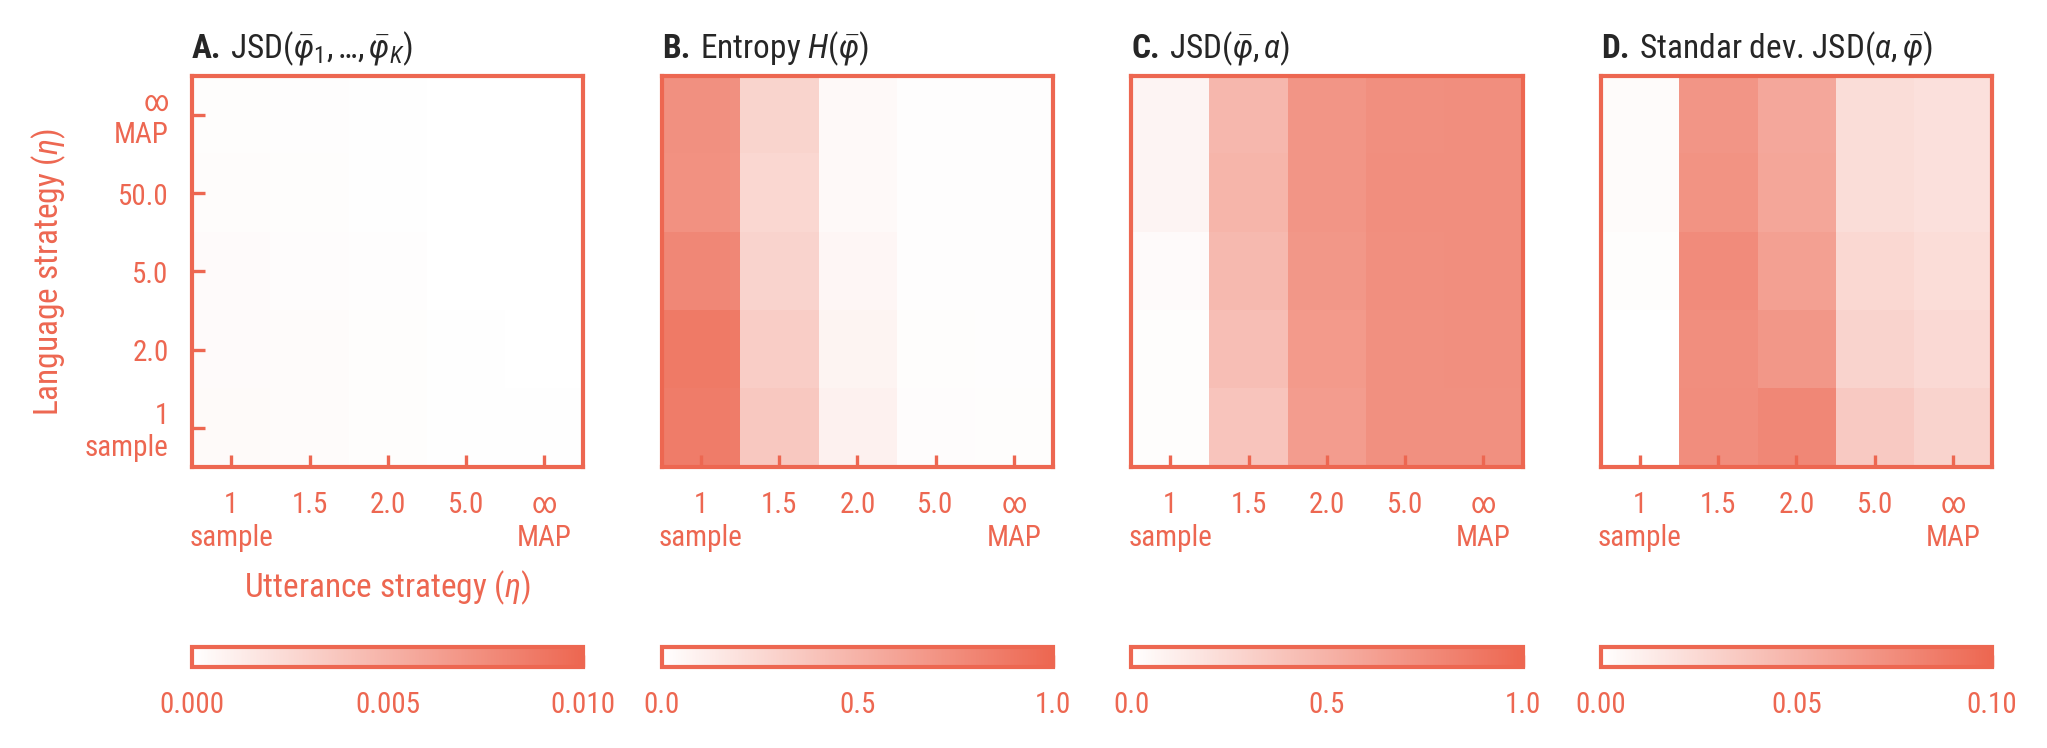

In [202]:
# #plot
# df = means[means['gamma'] == np.inf]
# props = {
#     'extremexlabels': ['1\nsample', '$\infty$\nMAP'],
#     'extremeylabels': ['$\infty$\nMAP', '1\nsample'],
#     'vmin':0, 
# #     'vmax':.08,
#     'cbarpad': .6,
#     'annotation_templ': '',
#     'colorbar': True,
# }

# ax1 = subplot(141)
# p = props.copy()
# p['vmax'] = 0.01
# # p['cmap'] = CustomCmap('white', 'blue')
# show_heatmap(df, 'jsd_phis', props=p, aspect=1)
# title(r'$\mathsf{JSD}(\bar{\varphi}_1, \dots, \bar{\varphi}_K)$')
# ylabel('Language strategy ($\eta$)')
# xlabel('Utterance strategy ($\eta$)')


# ax2 = subplot(142)
# p = props.copy()
# p['ylabels']=False
# p['vmax'] = 1
# show_heatmap(df, 'entropy_mphi', props=p, aspect=1)
# title(r'Entropy $H(\bar{\varphi})$')


# ax3 = subplot(143)
# p = props.copy()
# p['ylabels']=False
# p['vmax'] = 1
# show_heatmap(df, 'jsd_alpha_mphi', props=p, aspect=1)
# title(r'$\mathsf{JSD}(\bar{\varphi}, \alpha)$')

# ax4 = subplot(144)
# p = props.copy()
# p['ylabels']=False
# p['vmax'] = .1
# # p['cmap'] = CustomCmap('white', 'green')
# show_heatmap(df, 'std_alpha_mphi', props=p, aspect=1)
# title(r'Standar dev. $\mathsf{JSD}(\alpha, \bar{\varphi})}$')

# restyle_title(ax1,ax2,ax3, ax4);

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/colors.py:861: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


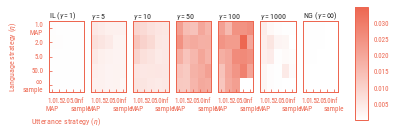

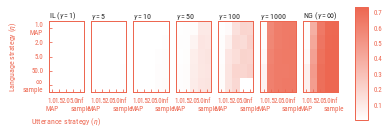

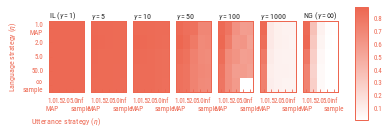

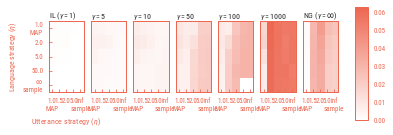

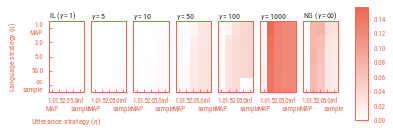

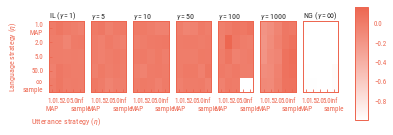

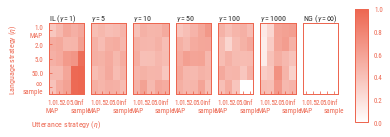

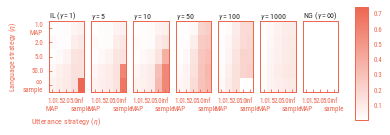

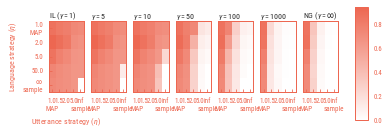

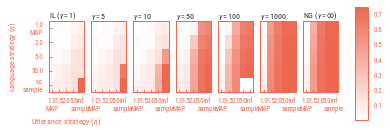

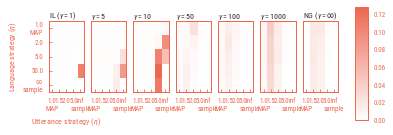

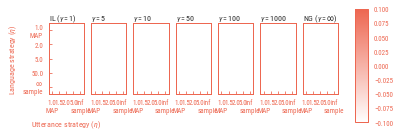

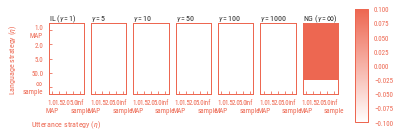

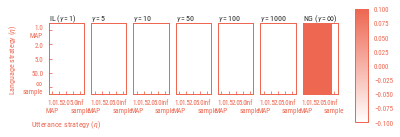

In [184]:
for name in means.columns:
    if name in ['eta', 'gamma', 'zeta']: continue
    show(name)
    savefig(name+'.png', bbox_inches='tight')

# Analysis of BNG ($\gamma=\infty$)

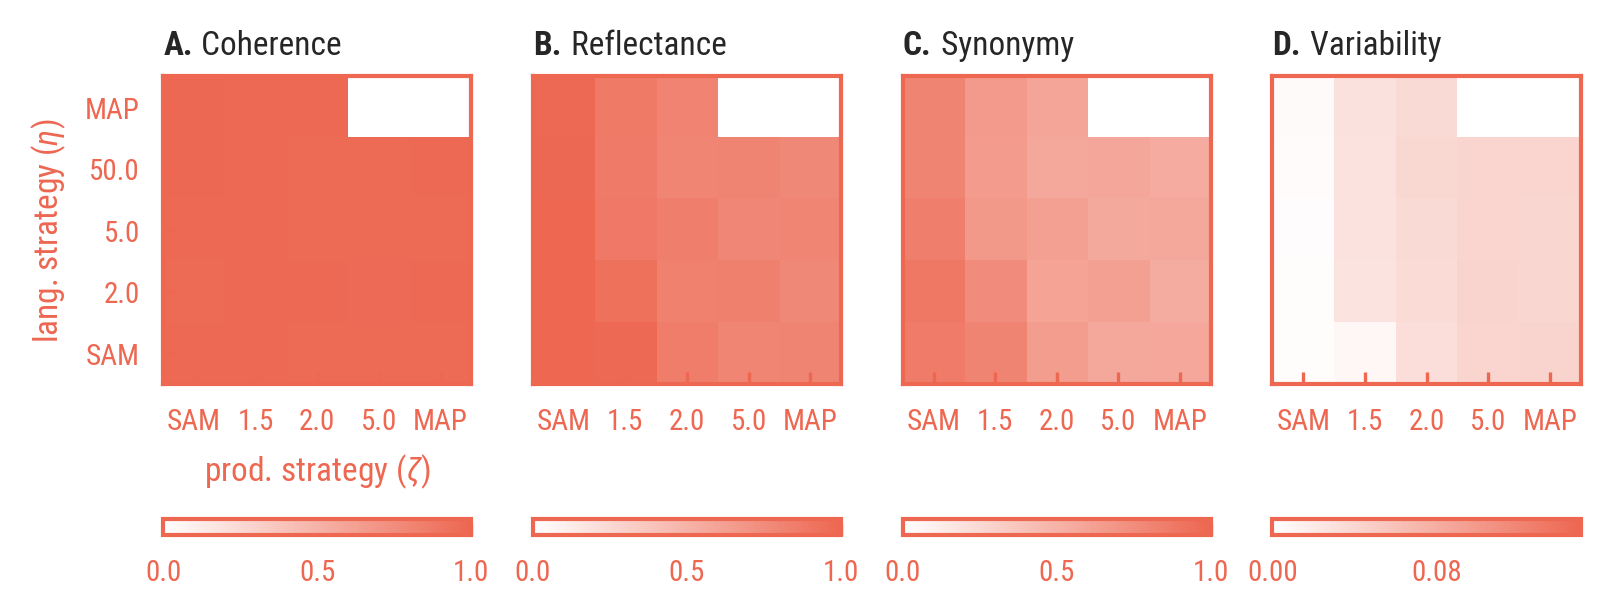

In [16]:
#plot
df = means[means['gamma'] == 100]
props = {
    'extremexlabels': ['SAM', 'MAP'],
    'extremeylabels': ['MAP', 'SAM'],
    'vmin':0, 
    'cbarpad': .45,
    'annotation_templ': '',
    'colorbar': True,
}

figure(figsize=cm2inch(12,4))

# Coherence
ax1 = subplot(141)
p = props.copy()
p['vmin'] = 0
# p.pop('vmin')
p['vmax'] = 1
p['cbar_nticks'] = 2
show_heatmap(df, 'coherence', props=p, aspect=1)
title(r'Coherence')
ylabel('lang. strategy ($\eta$)')
xlabel('prod. strategy ($\zeta$)')

# Reflectance
ax2 = subplot(142)
p = props.copy()
p.pop('vmin')
p['ylabels']=False
p['vmin'] = 0
p['vmax'] = 1
# p['cbar_nticks'] = 4
show_heatmap(df, 'reflectance', props=p, aspect=1)
title(r'Reflectance')

# Synonymy
ax3 = subplot(143)
p = props.copy()
p['ylabels']=False
p['vmax'] = 1
show_heatmap(df, 'synonymy', props=p, aspect=1)
title('Synonymy')

# Variability
ax4 = subplot(144)
p = props.copy()
p['ylabels']=False
p['vmax'] = .15
show_heatmap(df, 'std_alpha_mphi', props=p, aspect=1)
title('Variability')

restyle_title(ax1,ax2,ax3,ax4,y=1.1);

subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.2)
# savefig('BNG06-naming-game-strategies.png', bbox_inches='tight')
# copyfig('BNG06-naming-game-strategies.png')

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


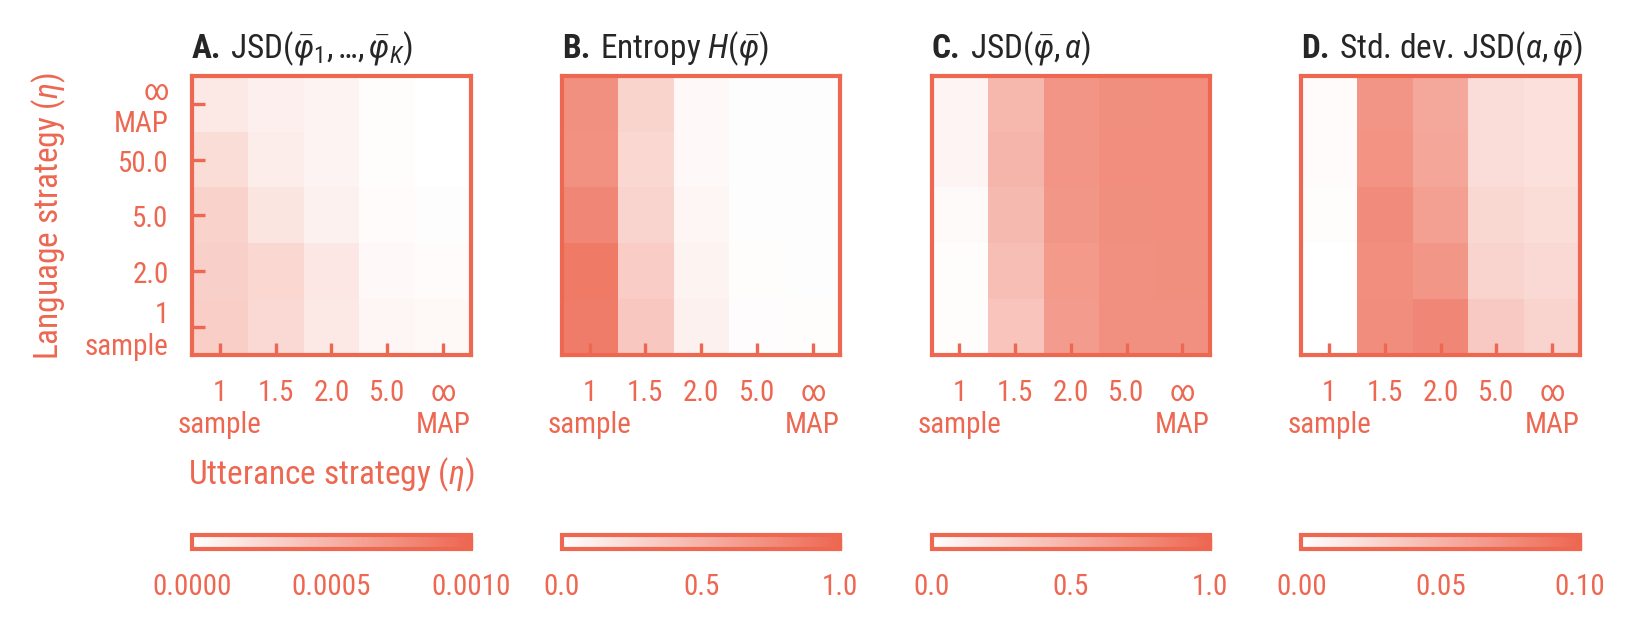

In [36]:
#plot
df = means[means['gamma'] == np.inf]
props = {
    'extremexlabels': ['1\nsample', '$\infty$\nMAP'],
    'extremeylabels': ['$\infty$\nMAP', '1\nsample'],
    'vmin':0, 
    'cbarpad': .6,
    'annotation_templ': '',
    'colorbar': True,
}

figure(figsize=cm2inch(12,4))


# Phis
ax1 = subplot(141)
p = props.copy()
p['vmax'] = 0.001
show_heatmap(df, 'jsd_phis', props=p, aspect=1)
title(r'$\mathsf{JSD}(\bar{\varphi}_1, \dots, \bar{\varphi}_K)$')
ylabel('Language strategy ($\eta$)')
xlabel('Utterance strategy ($\eta$)')

# Entropy mean phi
ax2 = subplot(142)
p = props.copy()
p['ylabels']=False
p['vmax'] = 1
show_heatmap(df, 'entropy_mphi', props=p, aspect=1)
title(r'Entropy $H(\bar{\varphi})$')

# Distance alpha and mean phi
ax3 = subplot(143)
p = props.copy()
p['ylabels']=False
p['vmax'] = 1
show_heatmap(df, 'jsd_alpha_mphi', props=p, aspect=1)
title(r'$\mathsf{JSD}(\bar{\varphi}, \alpha)$')

# Stdev divergence between alpha and meanphi
ax4 = subplot(144)
p = props.copy()
p['ylabels']=False
p['vmax'] = .1
show_heatmap(df, 'std_alpha_mphi', props=p, aspect=1)
title(r'Std. dev. $\mathsf{JSD}(\alpha, \bar{\varphi})}$')

restyle_title(ax1,ax2,ax3, ax4, y=1.1);

subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('BNG06-naming-game-strategies.png', bbox_inches='tight')
copyfig('BNG06-naming-game-strategies.png')

In [203]:
entropy_alpha

0.86894062312035236

In [201]:
means.columns

Index(['gamma', 'eta', 'zeta', 'jsd_phis', 'jsd_alpha_mphi', 'entropy_mphi',
       'std_jsd_phis', 'std_alpha_mphi', 'pearson_r', 'pearson_r_p_value',
       'jsd_mphi_psi', 'entropy_psi', 'jsd_psi_alpha', 'jsd_psi_slices',
       'gamma.1', 'eta.1', 'zeta.1'],
      dtype='object')

In [6]:
# Plot 

def annotate_colorbar(text, y, x=1.22):
    gca().annotate(text, xy=(x, y), xytext=(1.3, y), xycoords='axes fraction',
                fontsize = 7.5, ha='left', va='center', 
                arrowprops=dict(facecolor='black', width=.5, headlength=4, headwidth=3))

def plot_result(name, props):
    props = settings[name]
    figure(figsize=cm2inch(8,8))
    ax=gca()
    df = means[name].unstack()
    if 'cmap' in props:
        cmap = props['cmap']
    else:
        cmap = CustomCmap('white', 'orange')
    im = imshow(df, aspect=1/2.5, interpolation='none', cmap=cmap,
               vmin=props['vmin'], vmax=props['vmax'])

    # Add text to every cell
    for i, (gamma, row) in enumerate(df.iterrows()):
        for j, (zeta, val) in enumerate(row.items()):
            txt = '{:.3f}'.format(val)
            gca().text(j, i, txt, va='center', ha='center', 
                       color='k', fontsize=5.5, alpha=.3)

    # labels
    if True:

        title(props['title'])

        ylabels = ['{}'.format(g) for g in df.index[:-1].tolist()]
        ylabels += ['(NG) $\infty$']
        ylabels[0] = '(IL) '+ ylabels[0]
        yticks(arange(len(df.index)), ylabels)
        ylabel('game type ($\gamma$)')

        xlabels = ['{}'.format(z) for z in df.columns]
        xlabels[0] = xlabels[0] + ' (sampler)'
        xlabels[-1] = xlabels[-1] + ' (MAP)'
        xticks(arange(len(df.columns)), xlabels)
        xlabel('strategy ($\zeta$)')

        restyle_title(ax)
        cb = colorbar(im, fraction=0.0295)
        tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator
        cb.update_ticks()


        if 'annotate_cb' in props:
            for ann in props['annotate_cb']:
                annotate_colorbar(**ann)

#     subplots_adjust(left=0, bottom=0, right=1, top=1)
#     savefig('BNG05-{}-results.png'.format(name), bbox_inches='tight')

# Plot all things    
plot_result('jsd_mphi_psi')

TypeError: plot_result() missing 1 required positional argument: 'props'

In [ ]:
# Generate all plots
for name in settings:
    plot_result(name);